In [6]:
%pylab nbagg
from tvb.simulator.lab import *
import os.path
from matplotlib import colors, cm
import time
import scipy.signal as sig

import numpy as np
import pandas as pd
import scipy.io

# downloaded library for peak detection in z time series
import peakdetect
from runmainsim import *
import tvbsim

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [58]:
patients = ['id001_ac', 'id002_cj', 'id014_rb']
patients = ['id001_ac']
for patient in patients:
    print patient
#     patient='cj'
    # 1000 = 1 second
    samplerate = 1000 # Hz
    sim_length = 30*samplerate

    ezregion = ['ctx-lh-bankssts']
    pzregion = ['ctx-lh-cuneus']
#     pzregion = []

    outputdir = os.path.join('/Users/adam2392/Documents/pydata/tvb_forwardsim/', patient)
    if not os.path.exists(outputdir):
        os.mkdir(outputdir)
    filename = os.path.join(outputdir, patient+'_sim_nez'+str(len(ezregion))+\
                                        '_npz'+str(len(pzregion))+'.npz')

    period = 1
    # x0c value = -2.05
    x0norm=-2.5
    x0ez=-1.6
    x0pz=-2.04
    
    # intialized hard coded parameters
    epileptor_r = 0.0002       # Temporal scaling in the third state variable
    epiks = -0.5                 # Permittivity coupling, fast to slow time scale
    epitt = 0.05               # time scale of simulation
    epitau = 10                # Temporal scaling coefficient in fifth st var

    # depends on epileptor variables of interest: it is where the x2-y2 var is
    varindex = [1]
    
    # parameters for heun-stochastic integrator
    heun_ts = 0.05
    noise_cov = np.array([0.001, 0.001, 0.,\
                    0.0001, 0.0001, 0.])
    
    root_dir = os.getcwd()
    project_dir = os.path.join(root_dir, "metadata/"+patient)
    print "Project directory for meta data is : ", project_dir
    print "File to be saved is: ", filename

    ####### Initialize files needed to 
    # convert seeg.xyz to seeg.txt file
    sensorsfile = os.path.join(project_dir, "seeg.xyz")
    newsensorsfile = os.path.join(project_dir, "seeg.txt")
    try:
        os.rename(sensorsfile, newsensorsfile)
    except:
        print "Already renamed seeg.xyz possibly!"

    # convert gain_inv-square.mat file into gain_inv-square.txt file
    gainmatfile = os.path.join(project_dir, "gain_inv-square.mat")
    newgainmatfile = os.path.join(project_dir, "gain_inv-square.txt")
    try:
        os.rename(gainmatfile, newgainmatfile)
    except:
        print "Already renamed gain_inv-square.mat possibly!"
    gainmatfile = newgainmatfile
    sensorsfile = newsensorsfile
    
    
    confile = os.path.join(project_dir, "connectivity.zip")
    ####################### 1. Structural Connectivity ########################
    con = initconn(confile)
    # determine what the regions are for this certain parcellation
    # and get the ez indices, pz indices desired
    regions = con.region_labels
    ezindices, pzindices = getindexofregion(regions, ezregion, pzregion)
    num_regions = len(regions)
    
    ####################### 2. Neural Mass Model @ Nodes ######################
    epileptors = initepileptor(epileptor_r, epiks, epitt, epitau, x0norm, \
                              x0ez, x0pz, ezindices, pzindices, num_regions)    
    ####################### 3. Integrator for Models ##########################
    heunint = initintegrator(heun_ts, noise_cov)
    ################## 4. Difference Coupling Between Nodes ###################
    coupl = initcoupling(a=1.)
    ############## 5. Import Sensor XYZ, Gain Matrix For Monitors #############
    monitors = initmonitors(period, sensorsfile, gainmatfile, varindex)
    
    # extract the seeg_xyz coords and the region centers
    seeg_xyz = tvbsim.util.extractseegxyz(sensorsfile)
    region_centers = con.centres
    
    # find the closest contact index and distance
    seeg_index, distance = tvbsim.util.findclosestcontact(ezindices, region_centers, seeg_xyz)
    
    # get the modified seeg xyz and gain matrix
    modseeg = tvbsim.util.movecontact(seeg_xyz, region_centers, ezindices, seeg_index)
    modgain = tvbsim.util.simplest_gain_matrix(modseeg.as_matrix(), region_centers)
    
    # modify the config of the monitors
    monitors[1].sensors.locations = modseeg
    monitors[1].gain = modgain
    
    # get initial conditions and then setup entire simulation configuration
    initcond = initconditions(x0norm, num_regions)
    sim, configs = setupconfig(epileptors, con, coupl, heunint, monitors, initcond)

id001_ac
Project directory for meta data is :  /Users/adam2392/Documents/tvb/metadata/id001_ac
File to be saved is:  /Users/adam2392/Documents/pydata/tvb_forwardsim/id001_ac/id001_ac_sim_nez1_npz1.npz
Already renamed seeg.xyz possibly!
Already renamed gain_inv-square.mat possibly!
is left
Closest contact to ezregion:  [[-46.4062 -68.0003  14.9149]]  is  OR'1
That is located at:            x     y     z
OR'1 -17.97 -4.23  4.62
It will move:  [28.436199999999999, 63.770299999999992, -10.294899999999998]
New location after movement is             x        y        z
OR'1 -46.4062 -68.0003  14.9149


In [59]:
# test if the new seeg locations have moved and if the gain matrix has been recomputed?
# get that contact
# seeg_contact = seeg_xyz.iloc[seeg_index].index[0]
# seeg_labels = np.array(seeg_xyz.index, dtype='str')
# print "Closest contact found was: ", seeg_contact
# print seeg_index, distance
# # display(seeg_xyz.head())
# ez_regionxyz = region_centers[ezindices]
# closest_seeg = seeg_xyz.iloc[seeg_index]

# electrodeindices = tvbsim.util.getallcontacts(seeg_labels, seeg_contact)

# # get the euclidean distance that will be moved for this electrode
# x_dist = closest_seeg['x'].values[0] - ez_regionxyz[0][0]
# y_dist = closest_seeg['y'].values[0] - ez_regionxyz[0][1]
# z_dist = closest_seeg['z'].values[0] - ez_regionxyz[0][2]
# distancetomove = [x_dist, y_dist, z_dist]

# print ez_regionxyz
# print closest_seeg
# print "distances: ", x_dist, y_dist, z_dist


# createa copy of the seeg_xyz df and modify the electrode
# new_seeg_xyz = seeg_xyz.copy()
# new_seeg_xyz.iloc[electrodeindices] = new_seeg_xyz.iloc[electrodeindices] + distancetomove

# display(seeg_xyz.iloc[electrodeindices])
# display(new_seeg_xyz.iloc[electrodeindices])
# display(modseeg.head())
# print modgain.shape

display(seeg_xyz.iloc[electrodeindices])
display(modseeg.iloc[electrodeindices])

monseeg = monitors[1]
print monseeg
print monseeg.sensors.locations.iloc[electrodeindices]
print monseeg.gain.shape

,x,y,z
OR'1,-17.97,-4.23,4.62
OR'2,-18.36,-2.37,7.56
OR'3,-18.75,-0.52,10.50
OR'4,-19.13,1.34,13.45
OR'5,-19.52,3.20,16.39
OR'6,-19.90,5.05,19.33
OR'7,-20.29,6.91,22.27
OR'8,-20.68,8.76,25.22
OR'9,-21.06,10.62,28.16
OR'10,-21.45,12.47,31.10


,x,y,z
OR'1,10.4662,59.5403,-5.6749
OR'2,10.0762,61.4003,-2.7349
OR'3,9.6862,63.2503,0.2051
OR'4,9.3062,65.1103,3.1551
OR'5,8.9162,66.9703,6.0951
OR'6,8.5362,68.8203,9.0351
OR'7,8.1462,70.6803,11.9751
OR'8,7.7562,72.5303,14.9251
OR'9,7.3762,74.3903,17.8651
OR'10,6.9862,76.2403,20.8051


iEEG(period=1.000000, voi=[1])
             x        y        z
OR'1   10.4662  59.5403  -5.6749
OR'2   10.0762  61.4003  -2.7349
OR'3    9.6862  63.2503   0.2051
OR'4    9.3062  65.1103   3.1551
OR'5    8.9162  66.9703   6.0951
OR'6    8.5362  68.8203   9.0351
OR'7    8.1462  70.6803  11.9751
OR'8    7.7562  72.5303  14.9251
OR'9    7.3762  74.3903  17.8651
OR'10   6.9862  76.2403  20.8051
OR'11   6.5962  78.1003  23.7451
OR'12   6.2162  79.9503  26.6951
OR'13   5.8262  81.8103  29.6351
OR'14   5.4462  83.6703  32.5751
(70, 84)


In [63]:
times, epilepts, seegts = runsim(sim, sim_length)

######################## POST PROCESSING #################################
# post process by cutting off first 5 seconds of simulation
# for now, don't, since intiial conditions
times, epits, seegts, zts = postprocts(epilepts, seegts, times)

# get the onset, offset times
onsettimes = None
offsettimes = None
try:
    onsettimes, offsettimes = findonsetoffset(zts[ezindices, :].squeeze())
except:
    print "Still not working..."

######################## SAVING ALL DATA #################################
regions = configs.connectivity.region_labels
# Save files
meta = {
    'x0ez':x0ez,
    'x0pz':x0pz,
    'x0norm':x0norm,
    'regions': regions,
    'regions_centers': configs.connectivity.centres,
    'seeg_contacts': configs.monitors[1].sensors.labels,
    'seeg_xyz': configs.monitors[1].sensors.locations,
    'ez': regions[ezindices],
    'pz': regions[pzindices],
    'ezindices': ezindices,
    'pzindices': pzindices,
    'onsettimes':onsettimes,
    'offsettimes':offsettimes,
    'patient':patient,
}

# save tseries
np.savez(filename, epits=epits, seegts=seegts, \
         times=times, zts=zts, metadata=meta)

In [58]:
display(configs.monitors[1].sensors.locations.iloc[electrodeindices])
print  configs.connectivity.centres[ezindices]

,x,y,z
OR'1,10.4662,59.5403,-5.6749
OR'2,10.0762,61.4003,-2.7349
OR'3,9.6862,63.2503,0.2051
OR'4,9.3062,65.1103,3.1551
OR'5,8.9162,66.9703,6.0951
OR'6,8.5362,68.8203,9.0351
OR'7,8.1462,70.6803,11.9751
OR'8,7.7562,72.5303,14.9251
OR'9,7.3762,74.3903,17.8651
OR'10,6.9862,76.2403,20.8051


[[-46.4062 -68.0003  14.9149]]


# 2. Visualize Epileptor and SEEG Simulated Results

In [55]:
patient = 'id014_rb'
patient = 'id001_ac'
eznum=1
pznum=1

outputdir = os.path.join('/Users/adam2392/Documents/pydata/tvb_forwardsim/', patient)
if not os.path.exists(outputdir):
    os.mkdir(outputdir)
filename = os.path.join(outputdir, patient+'_sim_nez'+str(eznum)+\
                                '_npz'+str(pznum)+'.npz')

data = np.load(filename)

# extract data and metadata from simulation
epits = data['epits']
zts = data['zts']
times = data['times']
seegts = data['seegts']

metadata = data['metadata'].item()

print filename
# print findonsetoffset(zts[ezindices,:])
print data.keys()
print "Meta data contains: ", metadata.keys()
print metadata['pzindices']

/Users/adam2392/Documents/pydata/tvb_forwardsim/id001_ac/id001_ac_sim_nez1_npz1.npz
['metadata', 'zts', 'seegts', 'epits', 'times']
Meta data contains:  ['patient', 'pz', 'onsettimes', 'seeg_xyz', 'x0ez', 'regions_centers', 'regions', 'seeg_contacts', 'offsettimes', 'x0pz', 'ez', 'pzindices', 'x0norm', 'ezindices']
[3]


ezreion is:  ['ctx-lh-bankssts']
pzregion is:  ['ctx-lh-cuneus']
x0 values are (ez, pz, norm):  -1.6 -2.04 -2.5
time series shape is:  (84, 30000)


<IPython.core.display.Javascript object>


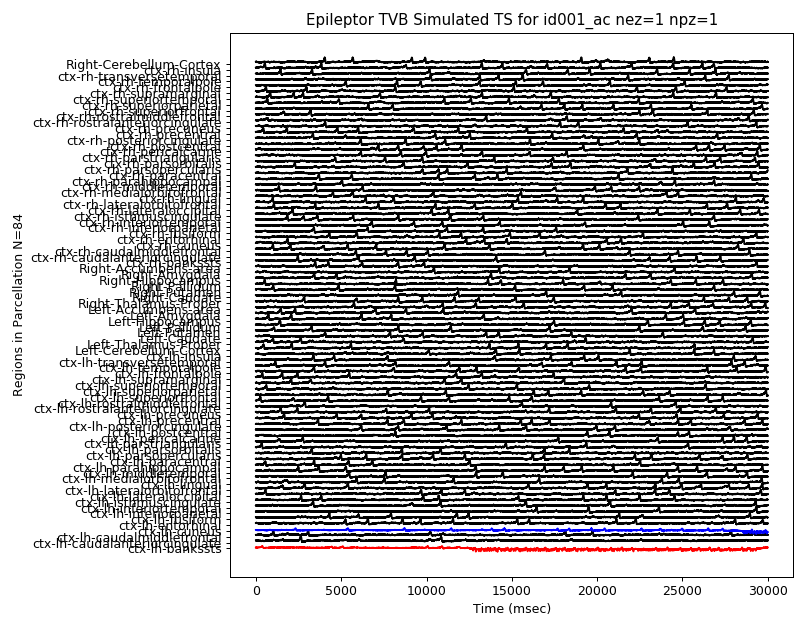

ezreion is:  ['ctx-lh-bankssts']
pzregion is:  ['ctx-lh-cuneus']
x0 values are (ez, pz, norm):  -1.6 -2.04 -2.5
time series shape is:  (84, 30000)


<IPython.core.display.Javascript object>


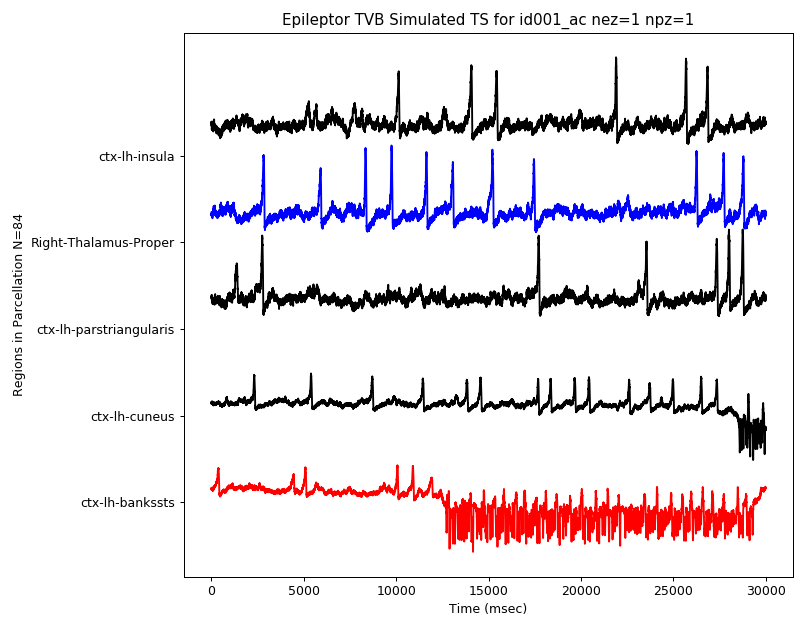

In [7]:
############################### PLOTTING OF EPILEPTOR TS ###############################
epifig = tvbsim.visualize.plotepileptorts(epits, times, metadata, patient, plotsubset=False)
epifigsubset = tvbsim.visualize.plotepileptorts(epits, times, metadata, patient, plotsubset=True)

(array([14]), array([ 0.]))
ezreion is:  ['ctx-lh-bankssts']
pzregion is:  ['ctx-lh-cuneus']
x0 values are (ez, pz, norm):  -1.6 -2.04 -2.5
time series shape is:  (70, 30000)
ez seeg index is:  14
regt is:  70
chanstoplot are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
2.40450209797
3.40450209797


<IPython.core.display.Javascript object>


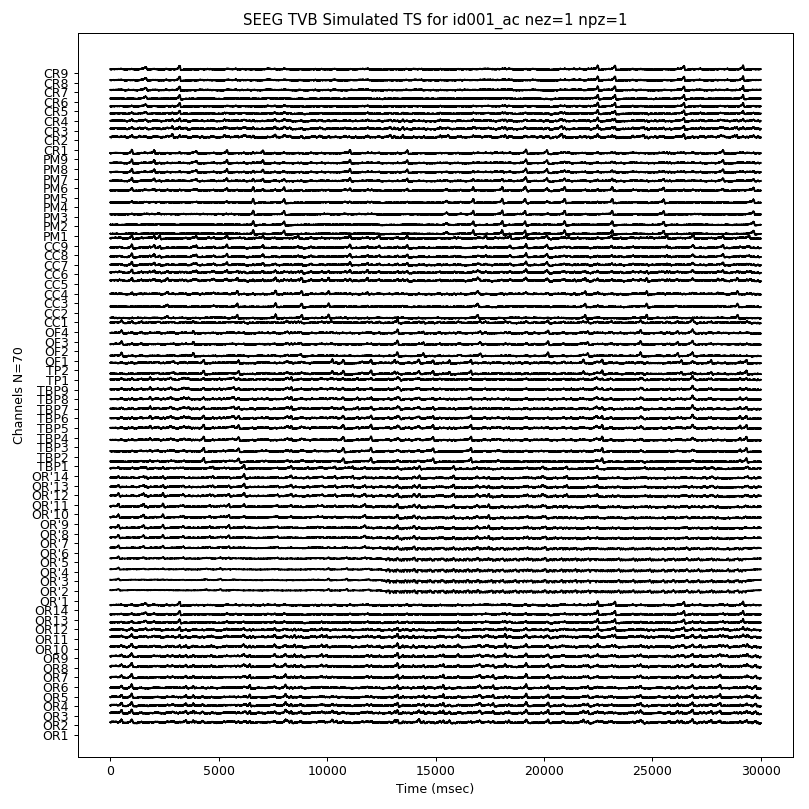

setting color
ezreion is:  ['ctx-lh-bankssts']
pzregion is:  ['ctx-lh-cuneus']
x0 values are (ez, pz, norm):  -1.6 -2.04 -2.5
time series shape is:  (70, 30000)
ez seeg index is:  14
regt is:  6
chanstoplot are:  [14 28 44 22 52 31]
2.40450209797
3.40450209797


<IPython.core.display.Javascript object>


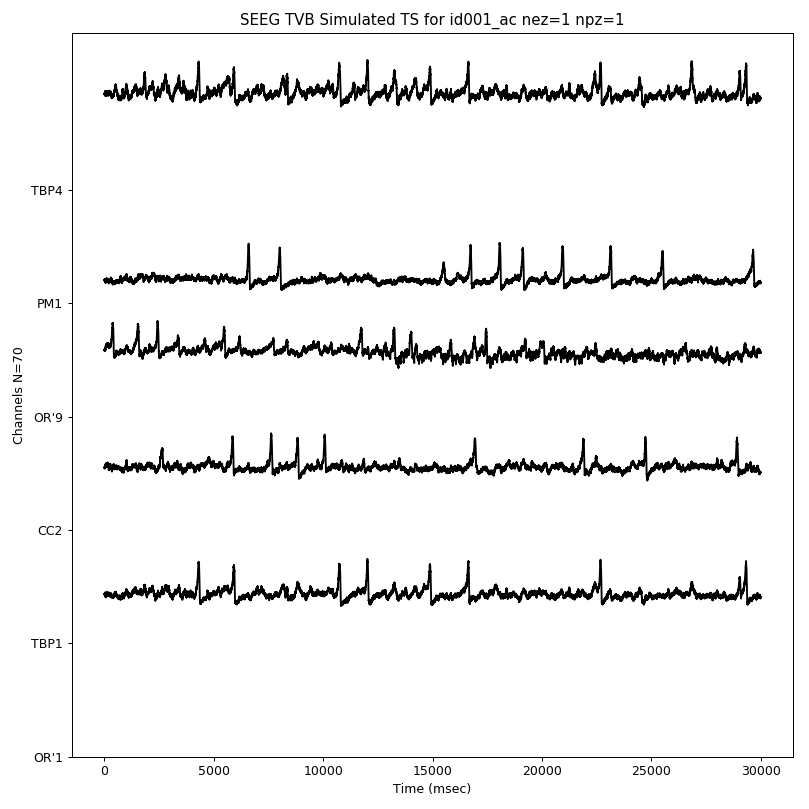

(array([14]), array([ 0.]))
            x        y        z
OR'1 -46.4062 -68.0003  14.9149


In [49]:
# get the distance to closest electrode
near_seeg = tvbsim.util.findclosestcontact(metadata['ezindices'], metadata['regions_centers'], metadata['seeg_xyz'])
print near_seeg
ezseegindex = near_seeg[0][0]
############################### PLOTTING OF SEEG TS ###############################
seegfig1 = tvbsim.visualize.plotseegts(seegts, times, metadata, patient, ezseegindex, plotsubset=False)
seegfig2 = tvbsim.visualize.plotseegts(seegts, times, metadata, patient, ezseegindex, plotsubset=True)

print near_seeg
print metadata['seeg_xyz'].iloc[near_seeg[0]]

# 3. Visualize Brain Cross-Section with SEEG Contacts

In [78]:
####################### 1. Structural Connectivity ########################
con = initconn(confile)
# determine what the regions are for this certain parcellation
# and get the ez indices, pz indices desired
regionlabels = con.region_labels
regioncentres = con.centres
ezindices, pzindices = getindexofregion(regions, ezregion, pzregion)
num_regions = len(regions)
    
# get xyz coords of region centres
xreg, yreg, zreg = regioncentres.T
numregions = regioncentres.shape[0]
righthemisphere_x = xreg[:numregions/2]
righthemisphere_y = yreg[:numregions/2]
lefthemisphere_x = xreg[numregions/2:]
lefthemisphere_y = yreg[numregions/2:]
    
# get xyz data for cortical surface
project_dir = os.path.join(root_dir, "metadata/"+patient)
cort_surf = surfaces.CorticalSurface.from_file(source_file=os.path.join(project_dir, "surface_cort.zip"))
cort_surf.configure()
cort_surf.summary_info
x_cort, y_cort, z_cort = cort_surf.vertices.T
    
# SEEG location as red 
seeg_xyz = tvbsim.util.extractseegxyz(sensorsfile)
xs, ys, zs = seeg_xyz.values.T # SEEG coordinates --------> (RB)'s electrodes concatenated
numcontacts = seeg_xyz.shape[0]

In [85]:
import re
elect = []
dipole = []
contacts = seeg_xyz.index

for element in range(0,contacts.shape[0]):
    #print ffff[i1_s]
    kpm = np.array(re.match("([A-Z]+[a-z]*[']*)([0-9]+)", contacts[element]).groups())
    #print kpm[0]  
    #print kpm[1]  
    #print int(kpm[1])
    elect.append(kpm[0])
    dipole.append(int(kpm[1]))
    
    
find_0 = []
nbr_contacts = []
for element_1 in range(0, len(dipole)):
    if dipole[element_1] == 1:
        find_0.append(element_1)
    
#print find_0
##### find_0  ---> index of dipole equal to 0

##### N.B

###### Number of electrodes is : len(find_0)
###### Number of contacts per an electrode i is nbr_contacts[i+1]

for element_2 in range(0, 2):
    nbr_contacts.append(find_0[element_2+1]-find_0[element_2])

for element_3 in range(2, len(find_0)-1):
    nbr_contacts.append(find_0[element_3+1]-find_0[element_3])

nbr_contacts.append(len(contacts)- find_0[len(find_0)-1])
print "Nbre_contacts_per_electrode:", nbr_contacts

#########################################################
#########################################################

print "Nbre_electrodes:", len(nbr_contacts)

incr_cont = np.zeros((len(nbr_contacts)), int)
incr_cont[0] = 0

for element_4 in range(0, len(nbr_contacts)):
    incr_cont[element_4] = incr_cont[element_4-1] + nbr_contacts[element_4]

print "Ending Index of electrodes:", incr_cont # To plot each electrode with diff color
nCols_new = len(nbr_contacts)

color_new = ['peru', 'dodgerblue', 'slategrey', 
             'skyblue', 'springgreen', 'fuchsia', 'limegreen', 
             'orangered',  'gold', 'crimson', 'teal', 'blueviolet', 'black', 'cyan', 'lightseagreen',
             'lightpink', 'red', 'indigo', 'mediumorchid', 'mediumspringgreen']

Nbre_contacts_per_electrode: [14, 14, 9, 2, 4, 9, 9, 9]
Nbre_electrodes: 8
Ending Index of electrodes: [14 28 37 39 43 52 61 70]


<IPython.core.display.Javascript object>


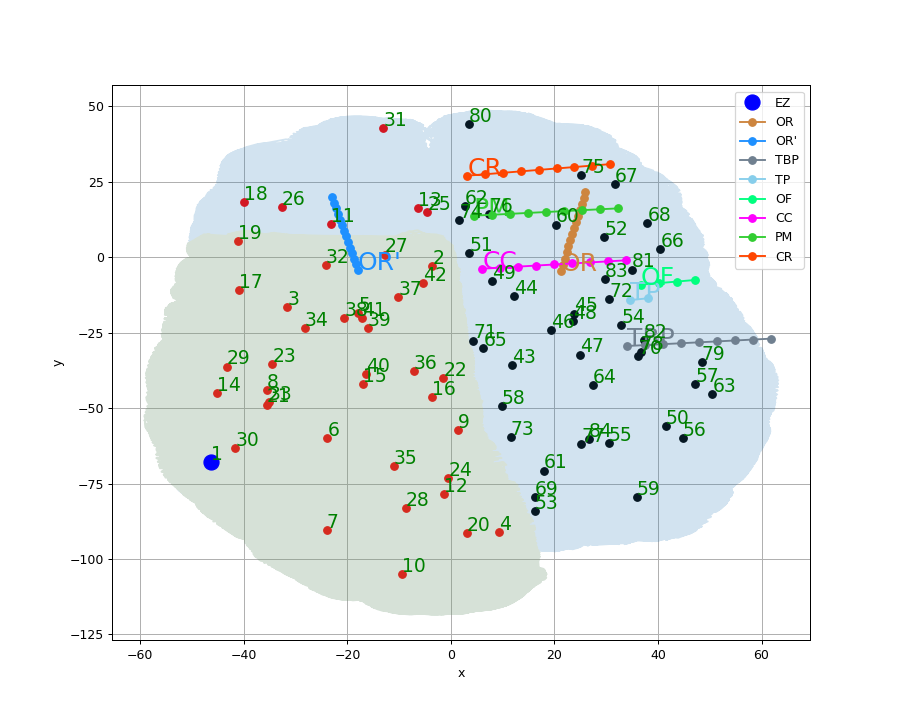

['ctx-lh-bankssts']


In [86]:
################# PLOTTING #################
# visualize brain cross-section
brainfig = plt.figure(figsize=(10,8))

############################ Plot Colored Circles for Regions XY Coords ############################
# divide into equal regions for left/right hemisphere
plt.plot(righthemisphere_x, righthemisphere_y, 'ro')
#and black for Left Hemisphere
plt.plot(lefthemisphere_x, lefthemisphere_y, 'ko')

#################################### Plot surface vertices  ###################################    
plt.plot(x_cort, y_cort, alpha=0.2) 
contourr = -4600
plt.plot(x_cort[: contourr + len(x_cort)//2], y_cort[: contourr + len(x_cort)//2], 'gold', alpha=0.1) 

#################################### label regions EZ ###################################    
print regionlabels[ezindices]
plot(xreg[ezindices] , yreg[ezindices], 'bo', markersize=12, label="EZ")  ### EZ

#################################### Elecrodes Implantation  ###################################    
ii = 0
# get number of contacts per electrode
incr_cont = np.zeros((len(nbr_contacts)), int)
incr_cont[0] = 0

for element_4 in range(0, len(nbr_contacts)):
    incr_cont[element_4] = incr_cont[element_4-1] + nbr_contacts[element_4]

# plot the contact points
plt.plot(xs[:incr_cont[ii]], ys[:incr_cont[ii]], 
          color_new[ii] , marker = 'o', label= elect[ii])

# add label at the first contact for electrode
plt.text(xs[0], ys[0],  str(elect[ii]), color = color_new[ii], fontsize = 20)


for ii in range(1,nCols_new):
    plt.plot(xs[incr_cont[ii-1]:incr_cont[ii]], ys[incr_cont[ii-1]:incr_cont[ii]], 
         color_new[ii] , marker = 'o', label= elect[incr_cont[ii-1]])
    plt.text(xs[incr_cont[ii-1]], ys[incr_cont[ii-1]],  str(elect[incr_cont[ii-1]]), color = color_new[ii], fontsize = 20)

for er in range(numregions):
    plt.text(xreg[er] , yreg[er] + 0.7, str(er+1), color = 'g', fontsize = 15)

xlabel('x')
ylabel('y')

plt.grid(True)
plt.legend()
plt.show()